In [25]:
# Importing Packages
import mne
import numpy as np
import pandas as pd
import neurokit2 as nk
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

Below are a few samples from the Neurokit2 publication Github demonstrating EMG, EOG, and ECG processing and visualization. Our project uses their EEG functions instead of ECG.

Sample #1 (EMG)

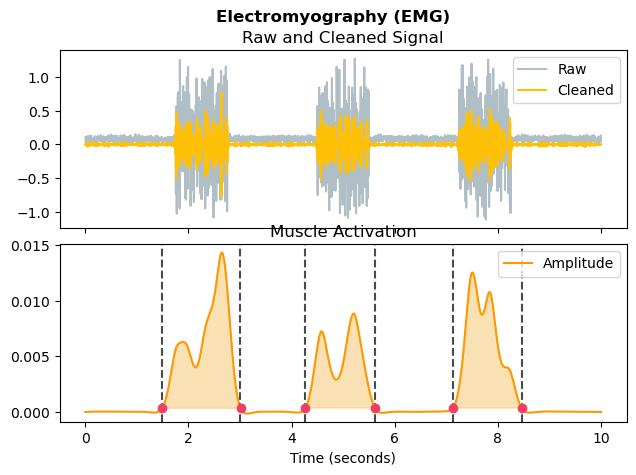

In [4]:
# Generate 10 seconds of EMG signal (recorded at 250 samples/second)
samp_emg = nk.emg_simulate(duration=10, sampling_rate=250, burst_number=3)

# Process it
samp_signals, samp_info = nk.emg_process(samp_emg, sampling_rate=250)

# Visualise the processing
nk.emg_plot(samp_signals, samp_info)

Sample #2 EOG

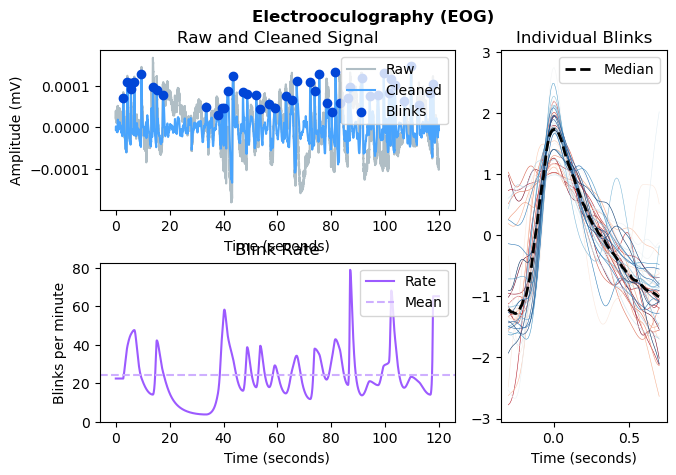

In [5]:
# Import EOG data
samp2_eog_signal = nk.data("eog_100hz")

# Process it
samp2_signals, samp2_info = nk.eog_process(samp2_eog_signal, sampling_rate=100)

# Plot
nk.eog_plot(samp2_signals, samp2_info)

Sample #3 (ECG)

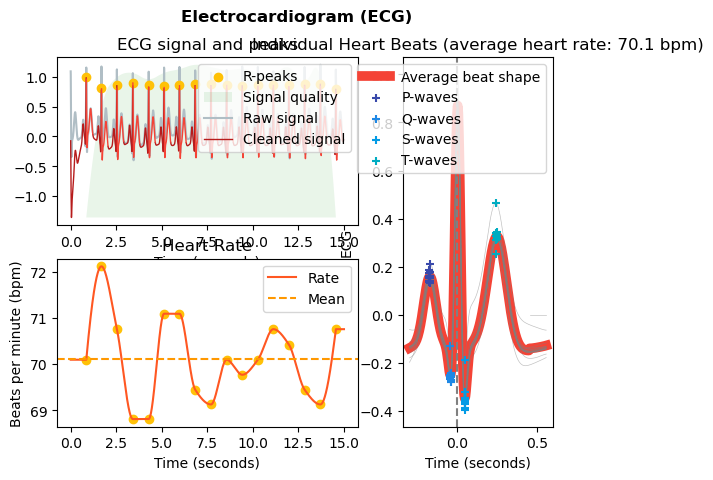

In [6]:
# Generate 15 seconds of ECG signal (recorded at 250 samples/second)
ecg = nk.ecg_simulate(duration=15, sampling_rate=250, heart_rate=70)

# Process it
signals, info = nk.ecg_process(ecg, sampling_rate=250)

# Visualise the processing
nk.ecg_plot(signals, info)

For our project, after the raw data was put into parquet files to be shared, we were able to run the Neurokit2 functions to extract features from the EEG, EOG, and EMG recordings. 

In [7]:
# Loading data into dataframe
df = pd.read_parquet("subj1.parquet")
df.head()

,EEG Fpz-Cz_1,EEG Pz-Oz_1,EOG horizontal_1,EMG Submental_1,Hyp_1
0,-0.000018,0.000007,0.000028,4.002038,0.0
1,-0.000013,0.000002,0.000014,4.003099,0.0
2,0.000005,-0.000005,0.000029,4.004188,0.0
3,-0.000006,-0.000008,0.000014,4.005303,0.0
4,0.000002,-0.000006,0.000020,4.006445,0.0


------------------------------------------------

**Starting with EMG:**

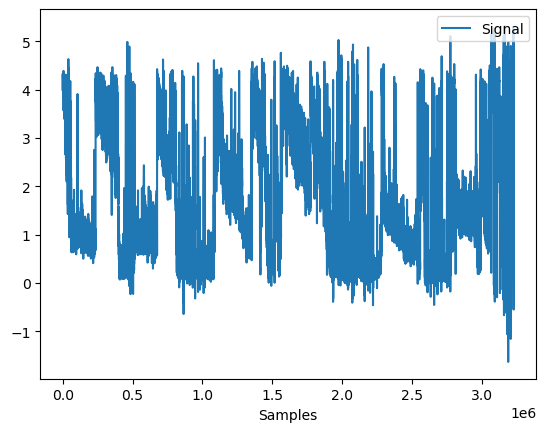

In [8]:
# Specifying EMG signal data, not super clean
emg_signal = df['EMG Submental_1']
nk.signal_plot(emg_signal)

**1.) Cleaning the signal**

In [9]:
# Making simple Bandpass filter to center and clean data emulating neurokit function
def AHM_emg_clean(signal, sampling_rate=100, lowcut=1, highcut=49, order=1):
    nyquist = sampling_rate / 2
    sos = sc.signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band', output='sos')
    filtered = sc.signal.sosfilt(sos, signal)
    return filtered

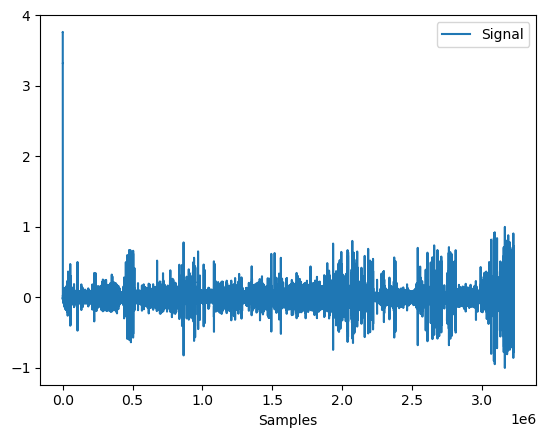

In [10]:
# Applying clean, huge spike at beginning is creating issues
emg_cleaned = AHM_emg_clean(emg_signal)
nk.signal_plot(emg_cleaned)

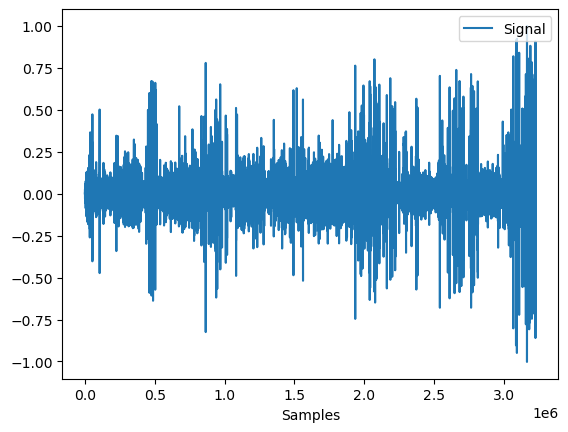

In [11]:
# Not the prettiest solution but setting first 200 values (2 seconds) to zero to eliminate large spike

emg_cleaned_0200 = emg_cleaned.copy()
emg_cleaned_0200[:200] = 0
nk.signal_plot(emg_cleaned_0200)

**2.) Extracting features**

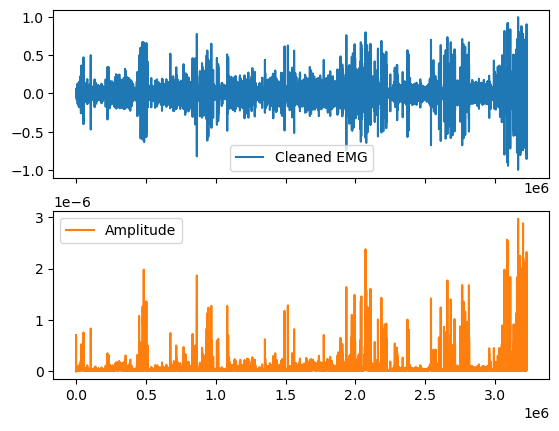

In [12]:
# Running neurokit2 amplitude function, it creates amplitude values from the signal

emg_amplitude = nk.emg_amplitude(emg_cleaned_0200)
fig = pd.DataFrame({"Cleaned EMG": emg_cleaned_0200, "Amplitude": emg_amplitude}).plot(subplots=True)

In [13]:
# Running neurokit2 activity funtion, it uses a gaussian mixture model to identify activation from amplitude data

emg_activity, info = nk.emg_activation(emg_amplitude=emg_amplitude)

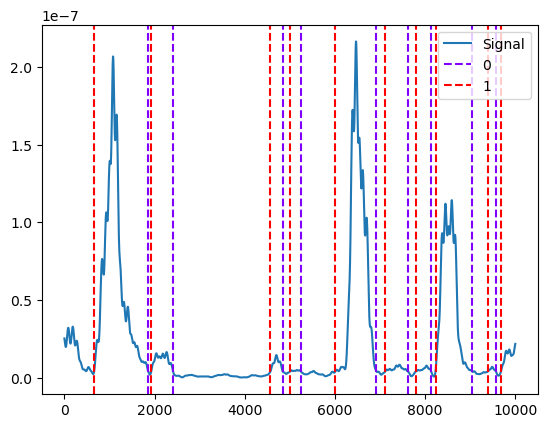

In [14]:
# Sample of what the identification looks like
activity_sample, info_sample = nk.emg_activation(emg_amplitude=emg_amplitude[2000000:2010000])
nk.events_plot([info_sample["EMG_Offsets"], info_sample["EMG_Onsets"]], emg_amplitude[2000000:2010000])

In [15]:
# Adding amplitude column to activity data
emg_activity['EMG_Amplitude'] = emg_amplitude

# Creating 30 sec epochs
event_onsets_emg = np.arange(0, len(emg_signal), 3000)
emg_epochs = nk.epochs_create(emg_activity, events=event_onsets_emg, sampling_rate=100)

/home/r3sen/.local/lib/python3.11/site-packages/neurokit2/epochs/eventrelated_utils.py:37: NeuroKitWarning: emg_eventrelated(): The duration of your epochs seems quite long. You might want to use emg_intervalrelated().
  warn(


,Label,Event_Onset,EMG_Activation,EMG_Amplitude_Mean,EMG_Amplitude_Max,EMG_Amplitude_SD,EMG_Amplitude_Max_Time,EMG_Bursts
1,1,0,1,3.291790e-07,6.998460e-07,2.314875e-07,2.000667,1.0
2,2,3000,1,1.759563e-08,2.230240e-08,2.760867e-09,19.586529,1.0
3,3,6000,0,NaN,NaN,NaN,NaN,NaN
4,4,9000,1,2.086021e-08,2.938142e-08,4.732392e-09,27.129043,2.0
5,5,12000,1,1.601815e-08,2.222536e-08,2.537544e-09,18.936312,3.0


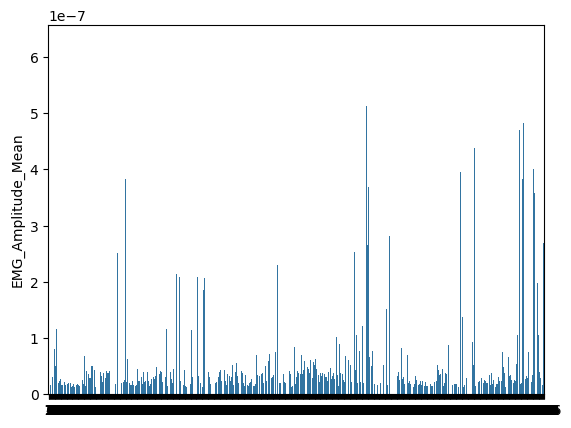

In [16]:
# Running event related function to extract event features

emg_event_data = nk.emg_eventrelated(emg_epochs)

# Sample plot of amplitude mean
sns.barplot(emg_event_data['EMG_Amplitude_Mean'])
emg_event_data.head()

Features are ready for analysis

----------------------
**Next section, EOG:**

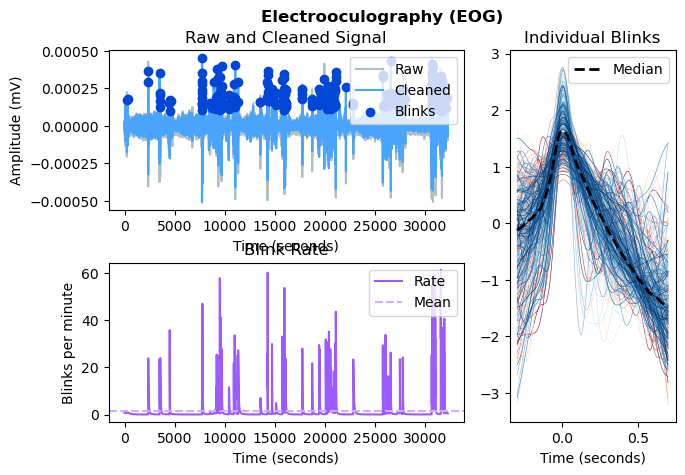

In [17]:
# Separating eog data
eog_df = df[["EOG horizontal_1"]].copy()
eog_signal = eog_df["EOG horizontal_1"]  

# Process signal
eog_signals, info = nk.eog_process(eog_signal, sampling_rate=100)

# Plot
nk.eog_plot(eog_signals, info)

/tmp/ipykernel_417/3101319920.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


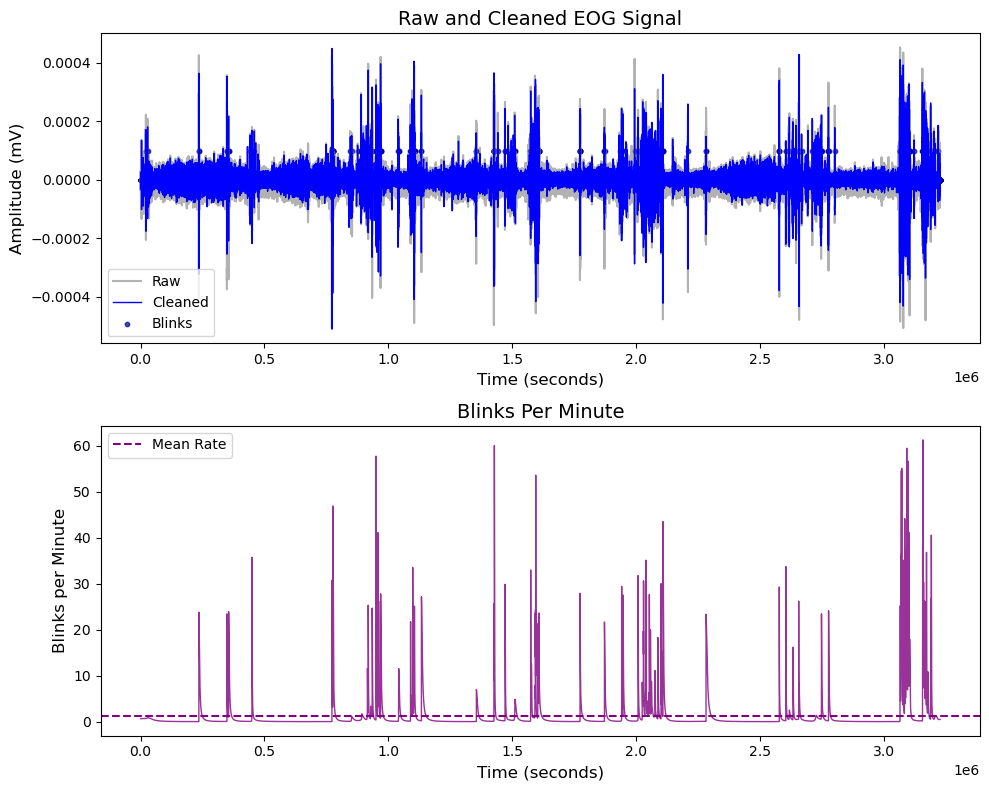

In [18]:
# Process EOG signal with specified sampling rate
eog_signals, eog_info = nk.eog_process(eog_signal, sampling_rate=100)

# Create a figure with 2 subplots (one column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot Raw and Cleaned EOG Signal
axes[0].plot(eog_signals.index, eog_signals["EOG_Raw"], label="Raw", color="gray", alpha=0.6)
axes[0].plot(eog_signals.index, eog_signals["EOG_Clean"], label="Cleaned", color="blue", linewidth=1)
axes[0].scatter(eog_signals.index, eog_signals["EOG_Blinks"] * 0.0001, label="Blinks", color="darkblue", alpha=0.7, s=10)
axes[0].set_title("Raw and Cleaned EOG Signal", fontsize=14)
axes[0].set_ylabel("Amplitude (mV)", fontsize=12)
axes[0].set_xlabel("Time (seconds)", fontsize=12)
axes[0].legend()

# Plot Blink Rate Over Time
axes[1].plot(eog_signals.index, eog_signals["EOG_Rate"], color="purple", linewidth=1, alpha=0.8)
axes[1].axhline(eog_signals["EOG_Rate"].mean(), color="purple", linestyle="dashed", label="Mean Rate")
axes[1].set_title("Blinks Per Minute", fontsize=14)
axes[1].set_ylabel("Blinks per Minute", fontsize=12)
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [19]:
# Creating 30 sec epochs
event_onsets_eog = np.arange(0, len(eog_signals), 3000)
eog_epochs = nk.epochs_create(eog_signals, events=event_onsets_eog, sampling_rate=100)

eog_epochs_df = nk.epochs_to_df(eog_epochs)

In [20]:
# Creating interval features dataframe
eog_intervals_df = nk.eog_intervalrelated(eog_epochs)

# Convert Label to numeric type
eog_intervals_df["Label"] = pd.to_numeric(eog_intervals_df["Label"], errors="coerce")

eog_intervals_df.dropna(subset=["Label"], inplace=True)

# Convert Label to int if you want integer epoch labels
eog_intervals_df["Label"] = eog_intervals_df["Label"].astype(int)

In [21]:
# Convert Label to numeric type
eog_intervals_df["Label"] = pd.to_numeric(eog_intervals_df["Label"], errors="coerce")

eog_intervals_df.dropna(subset=["Label"], inplace=True)

# Convert Label to int if you want integer epoch labels
eog_intervals_df["Label"] = eog_intervals_df["Label"].astype(int)

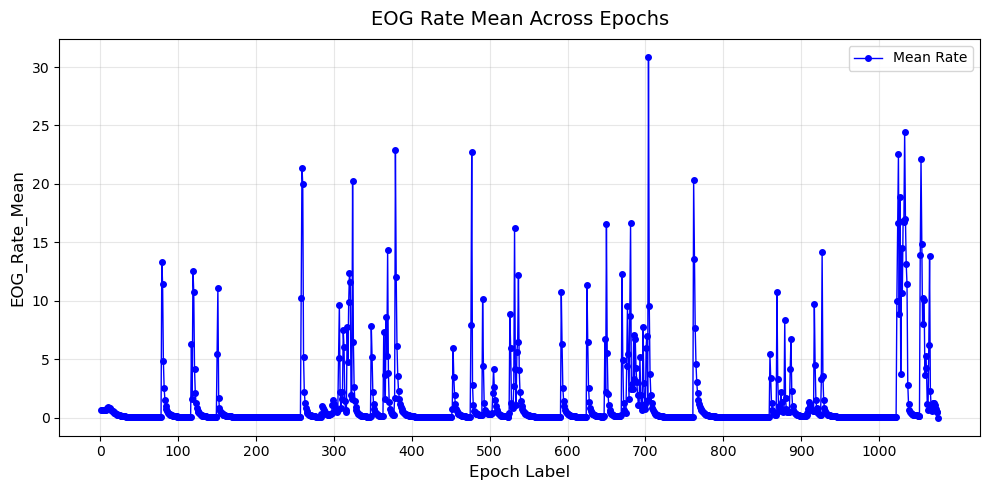

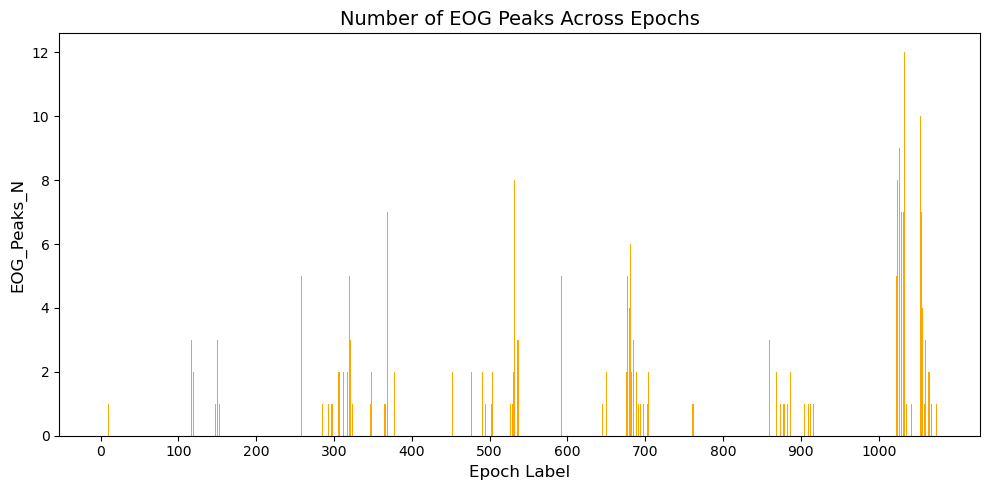

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot EOG_Rate_Mean vs. Label
ax.plot(eog_intervals_df["Label"], eog_intervals_df["EOG_Rate_Mean"],
        marker="o", markersize=4, linestyle="-", linewidth=1,
        color="blue", label="Mean Rate")

ax.set_title("EOG Rate Mean Across Epochs", fontsize=14, pad=10)
ax.set_xlabel("Epoch Label", fontsize=12)
ax.set_ylabel("EOG_Rate_Mean", fontsize=12)

# Group x-axis ticks in increments of 100
max_label = eog_intervals_df["Label"].max()  # Highest epoch label
ax.set_xticks(np.arange(0, max_label + 1, 100))

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(eog_intervals_df["Label"], eog_intervals_df["EOG_Peaks_N"], color="orange")

ax.set_title("Number of EOG Peaks Across Epochs", fontsize=14)
ax.set_xlabel("Epoch Label", fontsize=12)
ax.set_ylabel("EOG_Peaks_N", fontsize=12)

#Group x-axis ticks in increments of 100
max_label = eog_intervals_df["Label"].max()
ax.set_xticks(np.arange(0, max_label + 1, 100))
plt.tight_layout()
plt.show()

/home/r3sen/.local/lib/python3.11/site-packages/neurokit2/epochs/eventrelated_utils.py:37: NeuroKitWarning: eog_eventrelated(): The duration of your epochs seems quite long. You might want to use eog_intervalrelated().
  warn(


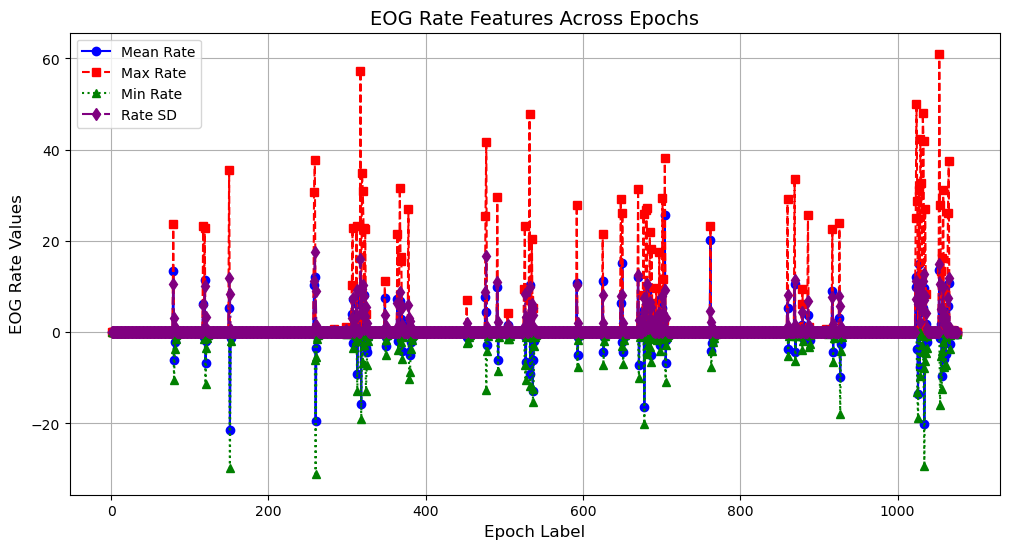

In [23]:
eog_events_df = nk.eog_eventrelated(eog_epochs)

# Convert Label to numeric type
eog_events_df["Label"] = pd.to_numeric(eog_events_df["Label"], errors="coerce")

eog_events_df.dropna(subset=["Label"], inplace=True)

# Convert Label to int if you want integer epoch labels
eog_events_df["Label"] = eog_events_df["Label"].astype(int)

plt.figure(figsize=(12, 6))

# Plot EOG_Rate_Mean
plt.plot(eog_events_df["Label"], eog_events_df["EOG_Rate_Mean"], label="Mean Rate",
         marker="o", linestyle="-", color="blue")

# Plot EOG_Rate_Max
plt.plot(eog_events_df["Label"], eog_events_df["EOG_Rate_Max"], label="Max Rate",
         marker="s", linestyle="--", color="red")

# Plot EOG_Rate_Min
plt.plot(eog_events_df["Label"], eog_events_df["EOG_Rate_Min"], label="Min Rate",
         marker="^", linestyle=":", color="green")

# Plot EOG_Rate_SD
plt.plot(eog_events_df["Label"], eog_events_df["EOG_Rate_SD"], label="Rate SD",
         marker="d", linestyle="-.", color="purple")

plt.xlabel("Epoch Label", fontsize=12)
plt.ylabel("EOG Rate Values", fontsize=12)
plt.title("EOG Rate Features Across Epochs", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


-----------------
**Next section: EEG**

In [26]:
# Extract EEG signals (ensure they exist in your dataset)
eeg_data = df[["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]].to_numpy().T  # Convert to NumPy array (transpose for MNE format)

# Create MNE Info object
sfreq = 100  # Set your sampling rate (change if different)
ch_names = ["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]
ch_types = ["eeg", "eeg"]

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create MNE RawArray object
raw_eeg = mne.io.RawArray(eeg_data, info)


Creating RawArray with float64 data, n_channels=2, n_times=3227999
    Range : 0 ... 3227998 =      0.000 ... 32279.980 secs
Ready.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bad Channels Detected: []


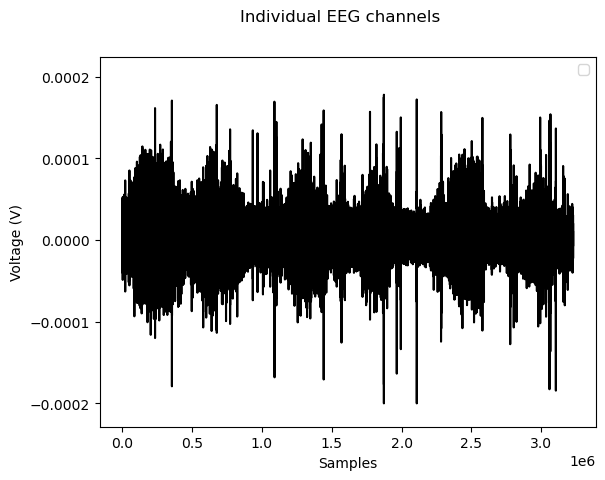

In [27]:
# Detect bad channels
bads, info = nk.eeg_badchannels(raw_eeg, distance_threshold=0.95, show=True)

# Print the detected bad channels
print("Bad Channels Detected:", bads)

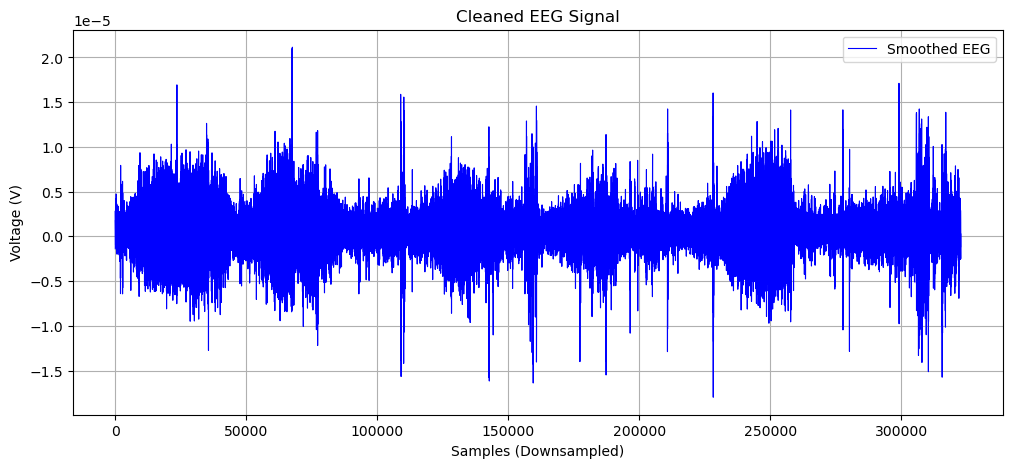

In [28]:
# Extract EEG signal (assuming you have a raw EEG object)
eeg_signal = raw_eeg.get_data()[0]  # Extract first channel

# Downsample the signal (reduce number of points for a cleaner plot)
downsample_factor = 10  # Adjust this for smoother plots
eeg_downsampled = eeg_signal[::downsample_factor]

# Apply a simple moving average filter to smooth the signal
window_size = 50  # Adjust for smoothness
eeg_smoothed = np.convolve(eeg_downsampled, np.ones(window_size)/window_size, mode='valid')

# Plot the cleaned EEG signal
plt.figure(figsize=(12, 5))
plt.plot(eeg_smoothed, color="blue", linewidth=0.8, label="Smoothed EEG")
plt.xlabel("Samples (Downsampled)")
plt.ylabel("Voltage (V)")
plt.title("Cleaned EEG Signal")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Compute EEG power using Welch's method
eeg_power = nk.eeg_power(raw_eeg, sampling_rate=100, method="welch")

# Extract specific power bands
delta_power = np.mean(eeg_power["Delta"])
theta_power = np.mean(eeg_power["Theta"])
alpha_power = np.mean(eeg_power["Alpha"])
beta_power = np.mean(eeg_power["Beta"])

# Print power values
print(f"Delta Power: {delta_power}")
print(f"Theta Power: {theta_power}")
print(f"Alpha Power: {alpha_power}")
print(f"Beta Power: {beta_power}")

Delta Power: 0.012788401466455724
Theta Power: 0.002333829364701923
Alpha Power: 0.0008504858920539121
Beta Power: 0.00047612771520176583


In [31]:
# Define epoch length (30s)
epoch_length = 30  # seconds
sampling_rate = 100  # Adjust based on your data
samples_per_epoch = epoch_length * sampling_rate

# Convert MNE Raw object to DataFrame
eeg_df = pd.DataFrame(raw_eeg.get_data().T, columns=raw_eeg.ch_names)  # Transpose to match timepoints

# Convert EEG DataFrame columns to numeric (force conversion)
eeg_df = eeg_df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (if needed)
eeg_df.dropna(inplace=True)

# OR: Fill NaN values with zero (if drop is not possible)
eeg_df.fillna(0, inplace=True)


# Convert EEG data from volts (V) to microvolts (µV) for proper scaling
eeg_df *= 1e6  # Now in microvolts

# Generate event onsets at fixed intervals (every 30s)
event_onsets = np.arange(0, len(eeg_df), samples_per_epoch)

# Create epochs
epochs = nk.epochs_create(eeg_df, events=event_onsets, sampling_rate=sampling_rate)


# Ensure all epochs contain numerical values
for epoch in epochs.keys():
    epochs[epoch] = epochs[epoch].apply(pd.to_numeric, errors='coerce')
    
# Convert epochs to DataFrame for inspection
eeg_epochs_df = nk.epochs_to_df(epochs)

print(eeg_epochs_df.head())

   EEG Fpz-Cz_1  EEG Pz-Oz_1  Index  Label      Time
0    -18.490410     6.842756      0      1  0.000000
1    -12.687343     1.935454      1      1  0.010003
2      4.830030    -4.646464      2      1  0.020007
3     -6.171618    -7.787137      3      1  0.030010
4      2.488441    -5.824216      4      1  0.040013


In [32]:
# Define your EEG channel names (adjust if needed)
eeg_channels = ["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]

# Create a list to store power values for each epoch.
epoch_power_features = []

# Iterate over epochs in numerical order (convert keys to int for proper sorting)
for key in sorted(epochs.keys(), key=int):
    epoch_data = epochs[key]
    
    # Select only the EEG channels (this will drop extra columns like "Index", "Label", "Time", etc.)
    try:
        epoch_eeg = epoch_data[eeg_channels]
    except KeyError:
        print(f"Epoch {key}: one or more EEG channel(s) missing.")
        continue

    # Convert the EEG data to numeric (force conversion in case some values are strings)
    epoch_eeg = epoch_eeg.apply(pd.to_numeric, errors='coerce')
    # Drop any rows with NaN values
    epoch_eeg = epoch_eeg.dropna()
    
    # If after cleaning the epoch is empty, skip it
    if epoch_eeg.empty:
        print(f"Epoch {key} is empty after cleaning; skipping.")
        continue

    # Now compute EEG power using Welch's method
    try:
        power_bands = nk.eeg_power(epoch_eeg, sampling_rate=sampling_rate, method="welch")
    except Exception as e:
        print(f"Epoch {key}: error computing EEG power: {e}")
        continue

    # Check if the expected key "Hz_1_4" (Delta) is in the result
    if "Hz_1_4" not in power_bands:
        print(f"Epoch {key}: power_bands keys are {list(power_bands.keys())}, skipping this epoch.")
        continue

# Map the returned keys to standard EEG bands
    epoch_features = {
        "Epoch": key,
        "Delta": np.mean(power_bands["Hz_1_4"]),
        "Theta": np.mean(power_bands["Hz_4_8"]),
        "Alpha": np.mean(power_bands["Hz_8_13"]),
        "Beta": np.mean(power_bands["Hz_13_30"]),
        "Gamma": np.mean(power_bands.get("Hz_30_80", [np.nan])),  # Optional Gamma band
    }
    epoch_power_features.append(epoch_features)

# Convert the list of epoch features into a DataFrame
eeg_epoch_power_df = pd.DataFrame(epoch_power_features)

# Print the first few rows of the resulting DataFrame
print(eeg_epoch_power_df.head())

  Epoch     Delta     Theta     Alpha      Beta     Gamma
0     1  0.178851  0.556169  0.316026  0.048283  0.023247
1     2  0.143499  0.311799  0.165421  0.046112  0.042361
2     3  0.085178  0.397235  0.166785  0.035458  0.012592
3     4  0.113562  0.429030  0.187841  0.036416  0.012837
4     5  0.137373  0.569296  0.286778  0.059488  0.018182


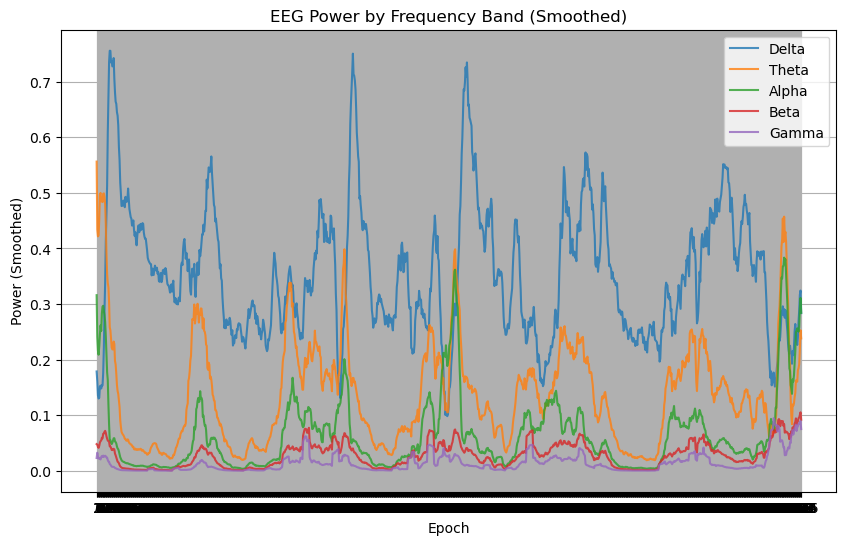

In [33]:
# Make a copy of the DataFrame
df_rolling = eeg_epoch_power_df.copy()

# Apply a rolling average (window size can be adjusted)
window_size = 10
df_rolling[["Delta","Theta","Alpha","Beta","Gamma"]] = (
    df_rolling[["Delta","Theta","Alpha","Beta","Gamma"]]
    .rolling(window_size, min_periods=1)
    .mean()
)

# Plot the smoothed data on a single plot
plt.figure(figsize=(10, 6))
plt.plot(df_rolling["Epoch"], df_rolling["Delta"], label="Delta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Theta"], label="Theta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Alpha"], label="Alpha", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Beta"], label="Beta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Gamma"], label="Gamma", alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Power (Smoothed)")
plt.title("EEG Power by Frequency Band (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

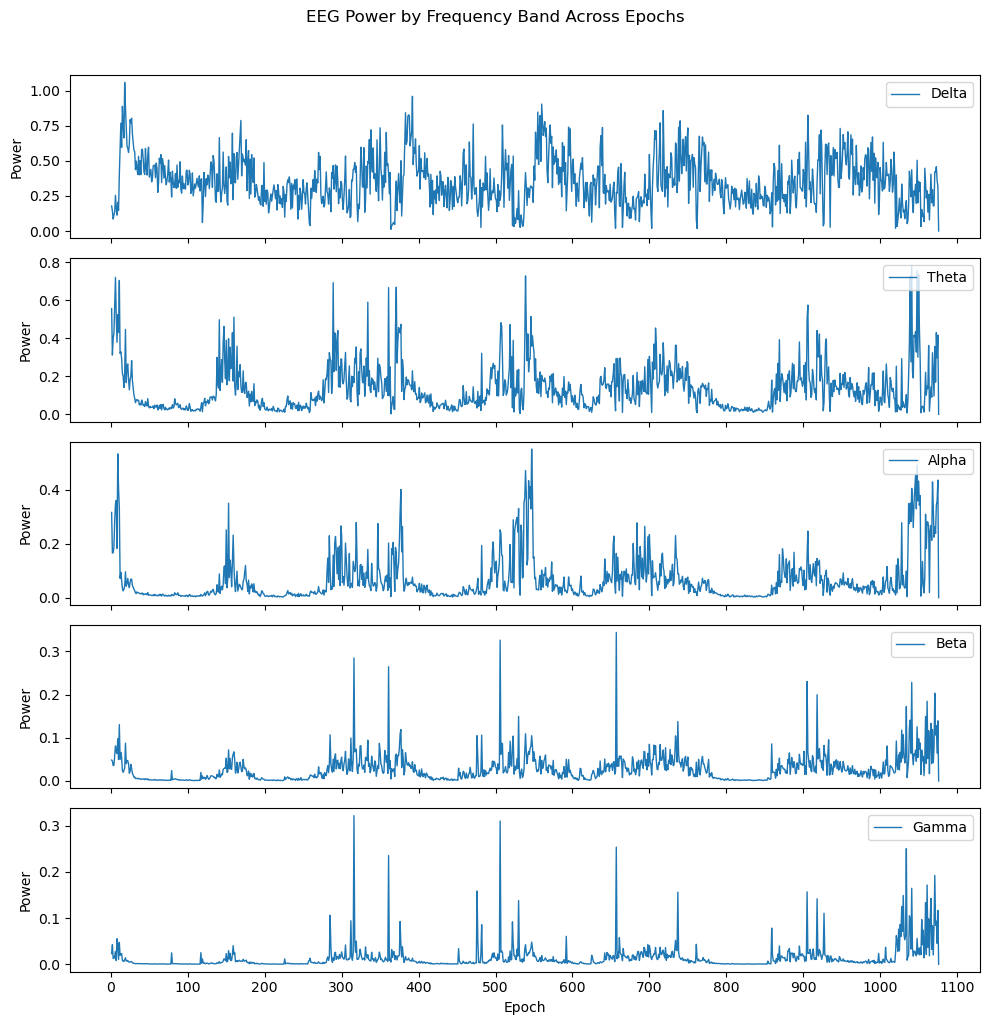

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Convert the Epoch column to integer if it's not already
eeg_epoch_power_df["Epoch"] = eeg_epoch_power_df["Epoch"].astype(int)

bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(10, 10), sharex=True)

for i, band in enumerate(bands):
    axes[i].plot(eeg_epoch_power_df["Epoch"], eeg_epoch_power_df[band], label=band, marker="", linewidth=1.0)
    axes[i].set_ylabel("Power")
    axes[i].legend(loc="upper right")
    # Set major ticks at every 100 epochs
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(100))

axes[-1].set_xlabel("Epoch")
plt.suptitle("EEG Power by Frequency Band Across Epochs", y=1.02)
plt.tight_layout()
plt.show()